<a href="https://colab.research.google.com/github/Research-SLIIT/Financial-Risk-Analyisis-Model/blob/main/svr_model_implementaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# =============================================================================
# Complete End-to-End Machine Learning Pipeline for Z-Score Prediction
# Google Colab Ready - Next Quarter Z-Score Prediction
# =============================================================================
# Step 1: Install and Import Required Libraries
# -----------------------------------------------------------------------------
!pip install -q scikit-learn pandas numpy matplotlib seaborn xgboost lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
# Scikit-learn imports
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [11]:
# =============================================================================
# Step 2: Load and Explore the Dataset
# =============================================================================
# Option 1: Upload from local machine (Google Colab)
from google.colab import files
uploaded = files.upload()
# Load the dataset
df = pd.read_csv('Datasett.csv')
# Display basic information
print("\n" + "="*60)
print("📊 DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
# print(f"\nFirst 5 rows:\n{df.head()}")
# print(f"\nMissing Values:\n{df.isnull().sum()}")
# print(f"\nBasic Statistics:\n{df.describe()}")

Saving Datasett.csv to Datasett (3).csv

📊 DATASET OVERVIEW
Shape: 1287 rows × 12 columns

Column Names:
['Company', 'QuarterDate', 'working_capital_to_total_assets', 'retained_earnings_to_total_assets', 'ebit_to_total_assets', 'mve_to_total_liabilities', 'sales_to_total_assets', 'current_ratio', 'debt_to_equity_ratio', 'net_profit_margin', 'z_score', 'z_score_next_quarter']

Data Types:
Company                               object
QuarterDate                           object
working_capital_to_total_assets      float64
retained_earnings_to_total_assets    float64
ebit_to_total_assets                 float64
mve_to_total_liabilities             float64
sales_to_total_assets                float64
current_ratio                        float64
debt_to_equity_ratio                 float64
net_profit_margin                    float64
z_score                              float64
z_score_next_quarter                 float64
dtype: object


In [13]:
# =============================================================================
# Step 3: Data Preprocessing
# =============================================================================
print("\n" + "="*60)
print("🔧 DATA PREPROCESSING")
print("="*60)
# 3.1: Convert QuarterDate to datetime for proper sorting
df['QuarterDate'] = pd.to_datetime(df['QuarterDate'], format='mixed', dayfirst=False)
df = df.sort_values(['Company', 'QuarterDate']).reset_index(drop=True)
print(f"Date range: {df['QuarterDate'].min()} to {df['QuarterDate'].max()}")
print(f"Number of unique companies: {df['Company'].nunique()}")
# 3.2: Handle missing values
print(f"\nMissing values before handling:\n{df.isnull().sum()}")
df = df.dropna()
print(f"\nDataset shape after removing missing values: {df.shape}")
# 3.3: Define Features and Target
# Drop Company and QuarterDate from features
feature_columns = [
    'working_capital_to_total_assets',
    'retained_earnings_to_total_assets',
    'ebit_to_total_assets',
    'mve_to_total_liabilities',
    'sales_to_total_assets',
    'current_ratio',
    'debt_to_equity_ratio',
    'net_profit_margin',
    'z_score'  # Include current z_score as feature
]
target_column = 'z_score_next_quarter'
X = df[feature_columns].copy()
y = df[target_column].copy()
print(f"\nFeatures used ({len(feature_columns)}):")
for col in feature_columns:
    print(f"  • {col}")
print(f"\nTarget variable: {target_column}")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


🔧 DATA PREPROCESSING
Date range: 2012-03-31 00:00:00 to 2025-09-30 00:00:00
Number of unique companies: 24

Missing values before handling:
Company                              0
QuarterDate                          0
working_capital_to_total_assets      0
retained_earnings_to_total_assets    0
ebit_to_total_assets                 0
mve_to_total_liabilities             0
sales_to_total_assets                0
current_ratio                        0
debt_to_equity_ratio                 0
net_profit_margin                    0
z_score                              0
z_score_next_quarter                 0
dtype: int64

Dataset shape after removing missing values: (1286, 12)

Features used (9):
  • working_capital_to_total_assets
  • retained_earnings_to_total_assets
  • ebit_to_total_assets
  • mve_to_total_liabilities
  • sales_to_total_assets
  • current_ratio
  • debt_to_equity_ratio
  • net_profit_margin
  • z_score

Target variable: z_score_next_quarter

Feature matrix shape: (1286, 9


📈 FEATURE ANALYSIS & VALIDATION


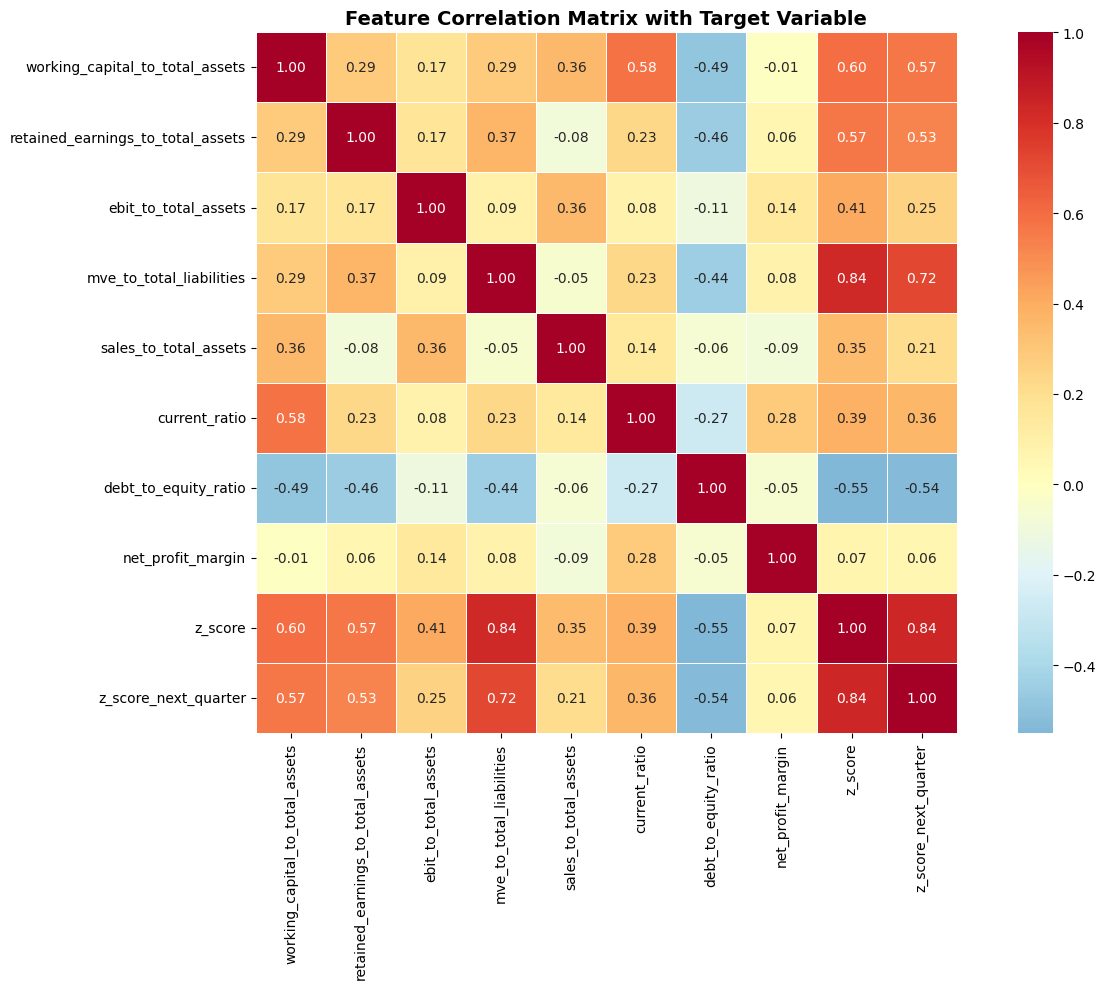


Correlation with target variable (next_quarter_z_score):
  z_score: 0.8412
  mve_to_total_liabilities: 0.7238
  working_capital_to_total_assets: 0.5674
  retained_earnings_to_total_assets: 0.5264
  current_ratio: 0.3627
  ebit_to_total_assets: 0.2527
  sales_to_total_assets: 0.2080
  net_profit_margin: 0.0577
  debt_to_equity_ratio: -0.5353


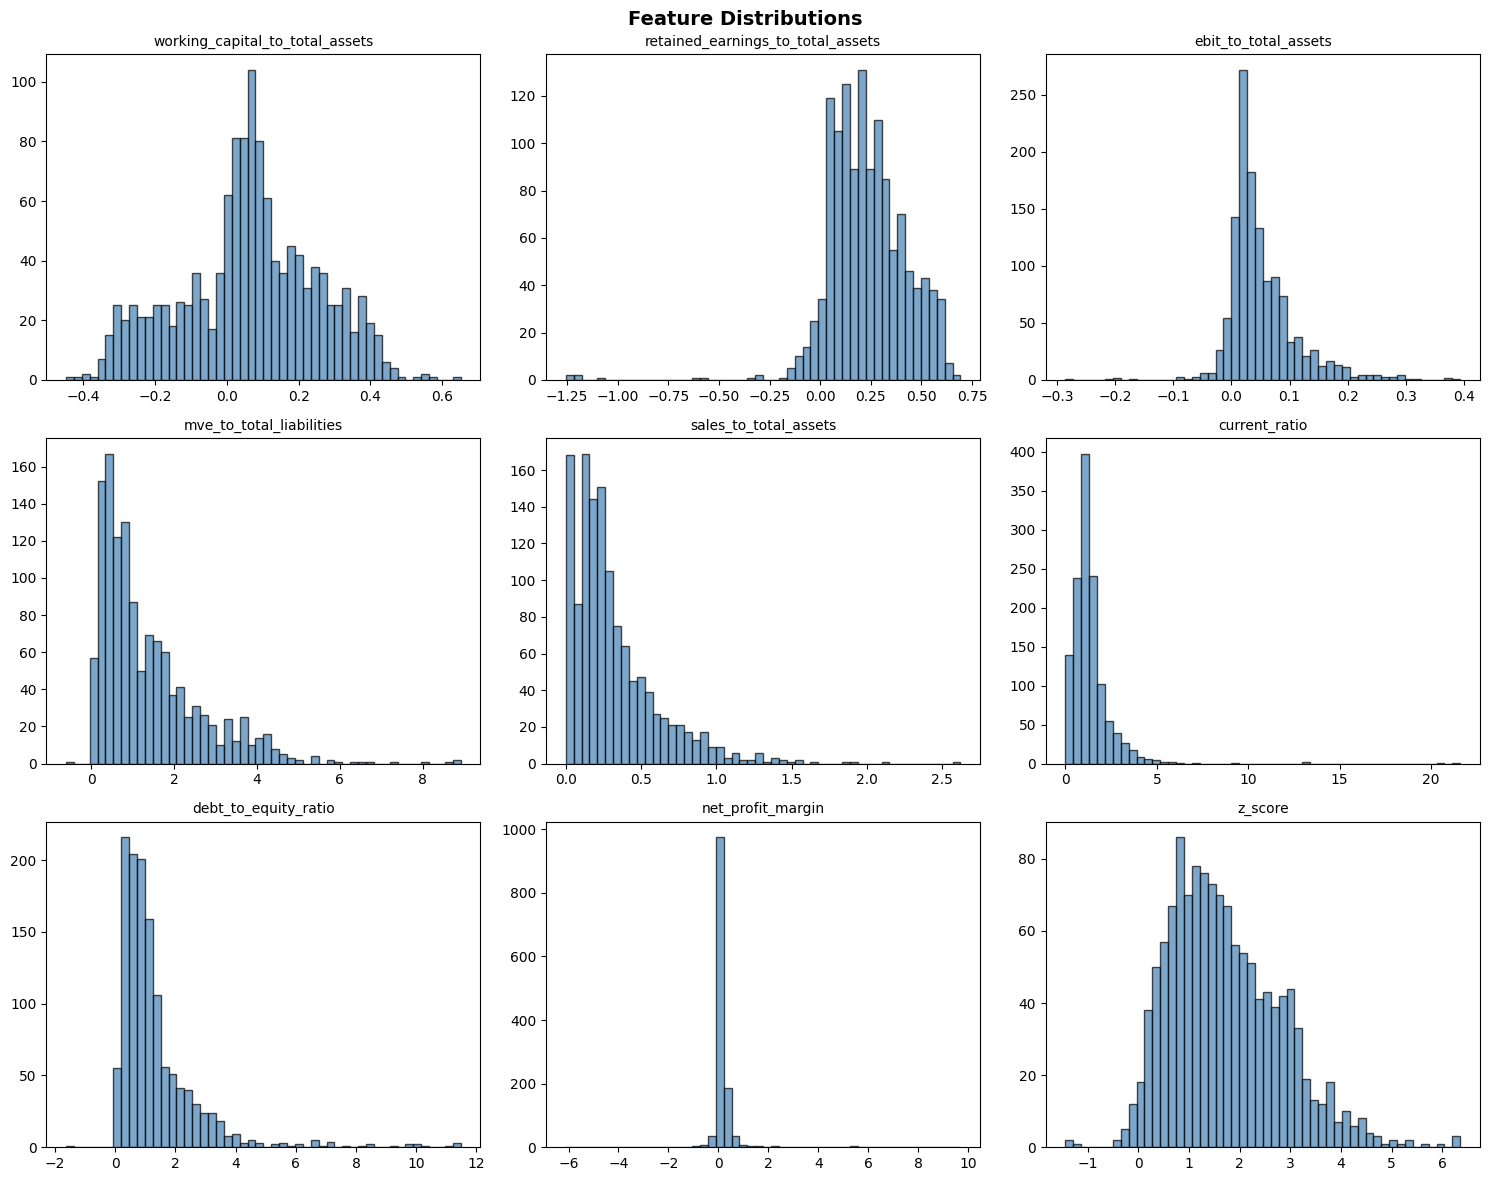


Outlier Analysis (using IQR method):
  working_capital_to_total_assets: 5 outliers (0.4%)
  retained_earnings_to_total_assets: 10 outliers (0.8%)
  ebit_to_total_assets: 85 outliers (6.6%)
  mve_to_total_liabilities: 56 outliers (4.4%)
  sales_to_total_assets: 78 outliers (6.1%)
  current_ratio: 87 outliers (6.8%)
  debt_to_equity_ratio: 85 outliers (6.6%)
  net_profit_margin: 141 outliers (11.0%)
  z_score: 11 outliers (0.9%)


In [14]:
# =============================================================================
# Step 4: Feature Analysis and Validation
# =============================================================================
print("\n" + "="*60)
print("📈 FEATURE ANALYSIS & VALIDATION")
print("="*60)
# 4.1: Correlation Analysis
plt.figure(figsize=(14, 10))
correlation_matrix = df[feature_columns + [target_column]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix with Target Variable', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150)
plt.show()
# 4.2: Feature-Target Correlation
print("\nCorrelation with target variable (next_quarter_z_score):")
target_corr = correlation_matrix[target_column].drop(target_column).sort_values(ascending=False)
for feat, corr in target_corr.items():
    print(f"  {feat}: {corr:.4f}")
# 4.3: Feature Distribution Check
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()
for idx, col in enumerate(feature_columns):
    axes[idx].hist(X[col], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f'{col}', fontsize=10)
    axes[idx].set_xlabel('')
plt.suptitle('Feature Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150)
plt.show()
# 4.4: Check for outliers using IQR
print("\nOutlier Analysis (using IQR method):")
for col in feature_columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()
    print(f"  {col}: {outliers} outliers ({outliers/len(X)*100:.1f}%)")

In [15]:
# =============================================================================
# Step 5: Train/Test Split by Date Order (Time Series Split)
# =============================================================================
print("\n" + "="*60)
print("📅 TIME-BASED TRAIN/TEST SPLIT")
print("="*60)
# Sort data by date to ensure temporal order
df_sorted = df.sort_values('QuarterDate').reset_index(drop=True)
# Get features and target from sorted data
X_sorted = df_sorted[feature_columns].copy()
y_sorted = df_sorted[target_column].copy()
# Split based on date order (80% train, 20% test)
split_ratio = 0.8
split_index = int(len(X_sorted) * split_ratio)
X_train = X_sorted.iloc[:split_index]
X_test = X_sorted.iloc[split_index:]
y_train = y_sorted.iloc[:split_index]
y_test = y_sorted.iloc[split_index:]
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTrain period: {df_sorted['QuarterDate'].iloc[:split_index].min()} to {df_sorted['QuarterDate'].iloc[:split_index].max()}")
print(f"Test period: {df_sorted['QuarterDate'].iloc[split_index:].min()} to {df_sorted['QuarterDate'].iloc[split_index:].max()}")



📅 TIME-BASED TRAIN/TEST SPLIT
Training set: 1028 samples (79.9%)
Testing set: 258 samples (20.1%)

Train period: 2012-03-31 00:00:00 to 2022-09-30 00:00:00
Test period: 2022-09-30 00:00:00 to 2025-09-30 00:00:00


In [16]:
# =============================================================================
# Step 6: Feature Scaling
# =============================================================================
print("\n" + "="*60)
print("⚖️ FEATURE SCALING")
print("="*60)
# Using RobustScaler as it's more resistant to outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Scaler: RobustScaler (resistant to outliers)")
print(f"Training features shape: {X_train_scaled.shape}")
print(f"Testing features shape: {X_test_scaled.shape}")


⚖️ FEATURE SCALING
Scaler: RobustScaler (resistant to outliers)
Training features shape: (1028, 9)
Testing features shape: (258, 9)


In [17]:
# =============================================================================
# Step 7: Define Models for Training
# =============================================================================
print("\n" + "="*60)
print("🤖 MODEL DEFINITIONS")
print("="*60)
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbose=-1),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'SVR': SVR(kernel='rbf', C=1.0)
}
print(f"Total models to train: {len(models)}")
for name in models.keys():
    print(f"  • {name}")


🤖 MODEL DEFINITIONS
Total models to train: 13
  • Linear Regression
  • Ridge Regression
  • Lasso Regression
  • ElasticNet
  • Decision Tree
  • Random Forest
  • Gradient Boosting
  • XGBoost
  • LightGBM
  • AdaBoost
  • Extra Trees
  • K-Nearest Neighbors
  • SVR


In [18]:
# =============================================================================
# Step 8: Cross-Validation with Time Series Split
# =============================================================================
print("\n" + "="*60)
print("🔄 CROSS-VALIDATION (Time Series Split)")
print("="*60)
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
cv_results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Cross-validation scores (negative MSE, we negate to get positive values)
    cv_rmse_scores = []
    cv_mae_scores = []
    cv_r2_scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
        X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Clone and fit model
        model_clone = model.__class__(**model.get_params())
        model_clone.fit(X_cv_train, y_cv_train)

        # Predictions
        y_cv_pred = model_clone.predict(X_cv_val)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
        mae = mean_absolute_error(y_cv_val, y_cv_pred)
        r2 = r2_score(y_cv_val, y_cv_pred)

        cv_rmse_scores.append(rmse)
        cv_mae_scores.append(mae)
        cv_r2_scores.append(r2)

    cv_results[name] = {
        'cv_rmse_mean': np.mean(cv_rmse_scores),
        'cv_rmse_std': np.std(cv_rmse_scores),
        'cv_mae_mean': np.mean(cv_mae_scores),
        'cv_mae_std': np.std(cv_mae_scores),
        'cv_r2_mean': np.mean(cv_r2_scores),
        'cv_r2_std': np.std(cv_r2_scores)
    }

    print(f"  CV RMSE: {cv_results[name]['cv_rmse_mean']:.4f} ± {cv_results[name]['cv_rmse_std']:.4f}")
    print(f"  CV MAE:  {cv_results[name]['cv_mae_mean']:.4f} ± {cv_results[name]['cv_mae_std']:.4f}")
    print(f"  CV R²:   {cv_results[name]['cv_r2_mean']:.4f} ± {cv_results[name]['cv_r2_std']:.4f}")



🔄 CROSS-VALIDATION (Time Series Split)

Evaluating Linear Regression...
  CV RMSE: 0.6201 ± 0.0937
  CV MAE:  0.4195 ± 0.0438
  CV R²:   0.6834 ± 0.0642

Evaluating Ridge Regression...
  CV RMSE: 0.6180 ± 0.0944
  CV MAE:  0.4186 ± 0.0447
  CV R²:   0.6854 ± 0.0650

Evaluating Lasso Regression...
  CV RMSE: 0.6426 ± 0.0765
  CV MAE:  0.4552 ± 0.0414
  CV R²:   0.6617 ± 0.0386

Evaluating ElasticNet...
  CV RMSE: 0.6257 ± 0.0786
  CV MAE:  0.4342 ± 0.0395
  CV R²:   0.6786 ± 0.0462

Evaluating Decision Tree...
  CV RMSE: 0.8671 ± 0.0798
  CV MAE:  0.5747 ± 0.0415
  CV R²:   0.3767 ± 0.1034

Evaluating Random Forest...
  CV RMSE: 0.6300 ± 0.0994
  CV MAE:  0.4221 ± 0.0512
  CV R²:   0.6746 ± 0.0611

Evaluating Gradient Boosting...
  CV RMSE: 0.6679 ± 0.0792
  CV MAE:  0.4410 ± 0.0417
  CV R²:   0.6346 ± 0.0413

Evaluating XGBoost...
  CV RMSE: 0.6646 ± 0.0748
  CV MAE:  0.4415 ± 0.0408
  CV R²:   0.6383 ± 0.0347

Evaluating LightGBM...
  CV RMSE: 0.6348 ± 0.1039
  CV MAE:  0.4329 ± 0.05

In [19]:
# =============================================================================
# Step 9: Train Final Models and Evaluate on Test Set
# =============================================================================
print("\n" + "="*60)
print("📊 FINAL MODEL TRAINING & EVALUATION")
print("="*60)
results = []
for name, model in models.items():
    # Train on full training set
    model.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'CV_RMSE_Mean': cv_results[name]['cv_rmse_mean'],
        'CV_RMSE_Std': cv_results[name]['cv_rmse_std'],
        'CV_R2_Mean': cv_results[name]['cv_r2_mean'],
        'CV_R2_Std': cv_results[name]['cv_r2_std']
    })

    print(f"\n{name}:")
    print(f"  Test RMSE: {rmse:.4f}")
    print(f"  Test MAE:  {mae:.4f}")
    print(f"  Test R²:   {r2:.4f}")
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE').reset_index(drop=True)
print("\n" + "="*60)
print("📋 MODEL COMPARISON TABLE (Sorted by RMSE)")
print("="*60)
print(results_df.to_string(index=False))



📊 FINAL MODEL TRAINING & EVALUATION

Linear Regression:
  Test RMSE: 0.4849
  Test MAE:  0.3777
  Test R²:   0.8156

Ridge Regression:
  Test RMSE: 0.4856
  Test MAE:  0.3783
  Test R²:   0.8151

Lasso Regression:
  Test RMSE: 0.5700
  Test MAE:  0.4446
  Test R²:   0.7452

ElasticNet:
  Test RMSE: 0.5405
  Test MAE:  0.4142
  Test R²:   0.7709

Decision Tree:
  Test RMSE: 0.8196
  Test MAE:  0.5665
  Test R²:   0.4732

Random Forest:
  Test RMSE: 0.4736
  Test MAE:  0.3689
  Test R²:   0.8241

Gradient Boosting:
  Test RMSE: 0.4706
  Test MAE:  0.3619
  Test R²:   0.8263

XGBoost:
  Test RMSE: 0.4606
  Test MAE:  0.3524
  Test R²:   0.8336

LightGBM:
  Test RMSE: 0.4461
  Test MAE:  0.3473
  Test R²:   0.8439

AdaBoost:
  Test RMSE: 0.4797
  Test MAE:  0.3782
  Test R²:   0.8195

Extra Trees:
  Test RMSE: 0.4648
  Test MAE:  0.3674
  Test R²:   0.8306

K-Nearest Neighbors:
  Test RMSE: 0.6316
  Test MAE:  0.4763
  Test R²:   0.6872

SVR:
  Test RMSE: 0.4206
  Test MAE:  0.3239
  Test

In [20]:
# =============================================================================
# Step 10: Automatically Select Best Model
# =============================================================================
print("\n" + "="*60)
print("🏆 BEST MODEL SELECTION")
print("="*60)
# Select best model based on lowest RMSE
best_model_name = results_df.iloc[0]['Model']
best_rmse = results_df.iloc[0]['RMSE']
best_mae = results_df.iloc[0]['MAE']
best_r2 = results_df.iloc[0]['R²']
print(f"\n🎯 BEST MODEL: {best_model_name}")
print(f"   • Test RMSE: {best_rmse:.4f}")
print(f"   • Test MAE:  {best_mae:.4f}")
print(f"   • Test R²:   {best_r2:.4f}")
print(f"   • CV RMSE:   {results_df.iloc[0]['CV_RMSE_Mean']:.4f} ± {results_df.iloc[0]['CV_RMSE_Std']:.4f}")
# Train the best model
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)


🏆 BEST MODEL SELECTION

🎯 BEST MODEL: SVR
   • Test RMSE: 0.4206
   • Test MAE:  0.3239
   • Test R²:   0.8612
   • CV RMSE:   0.6393 ± 0.1337


SVR()


📊 GENERATING VISUALIZATIONS


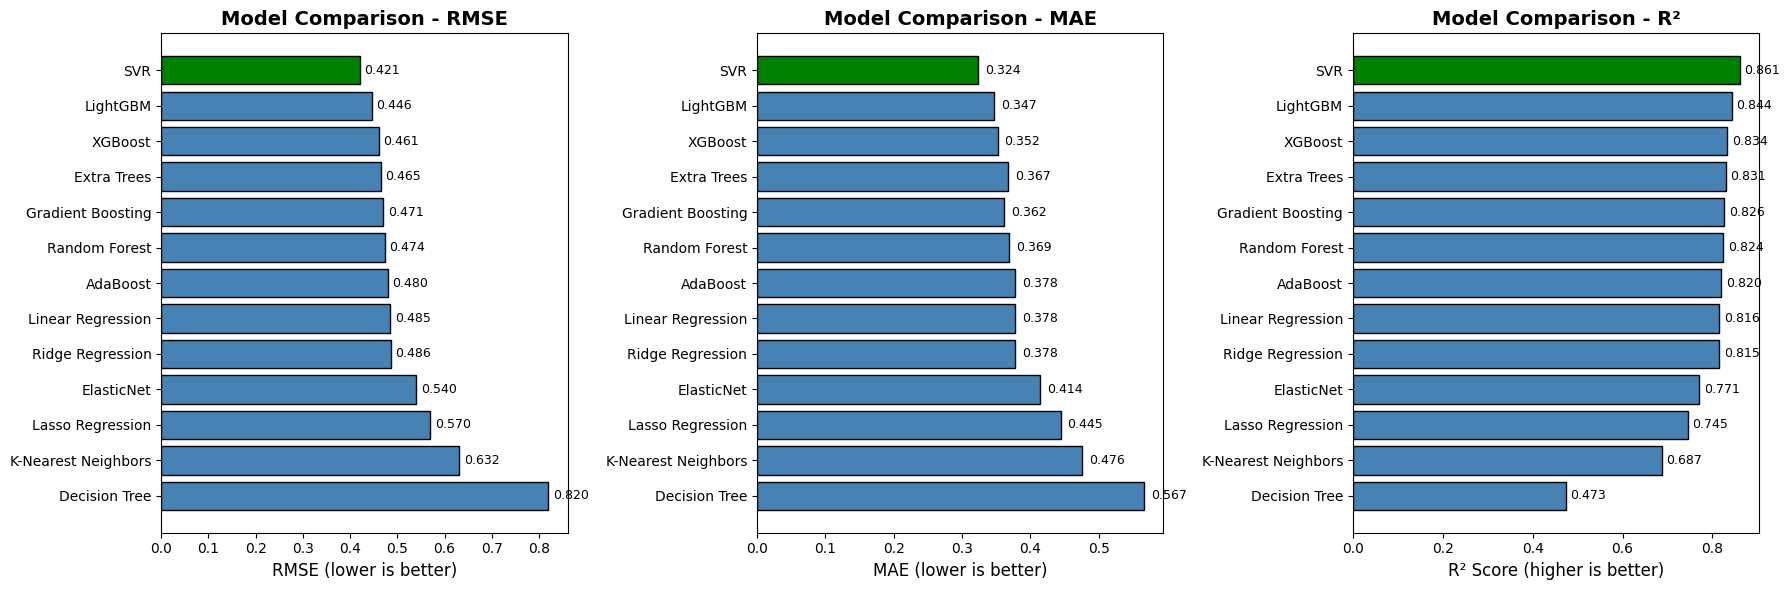

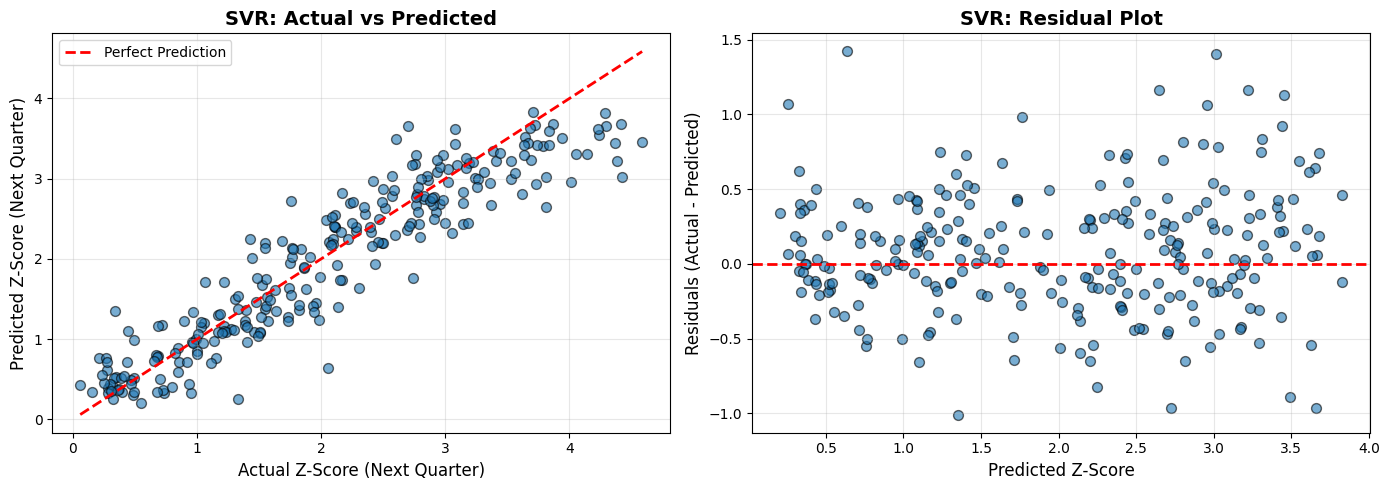

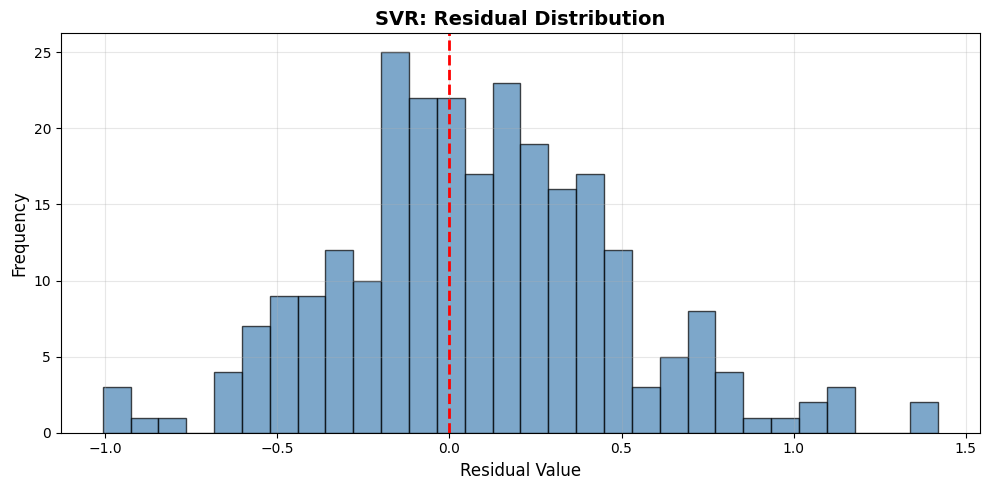

In [25]:
# =============================================================================
# Step 11: Visualization of Results
# =============================================================================
print("\n" + "="*60)
print("📊 GENERATING VISUALIZATIONS")
print("="*60)
# 11.1: Model Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# RMSE Comparison
ax1 = axes[0]
colors = ['green' if m == best_model_name else 'steelblue' for m in results_df['Model']]
ax1.barh(results_df['Model'], results_df['RMSE'], color=colors, edgecolor='black')
ax1.set_xlabel('RMSE (lower is better)', fontsize=12)
ax1.set_title('Model Comparison - RMSE', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
for i, v in enumerate(results_df['RMSE']):
    ax1.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)
# MAE Comparison
ax2 = axes[1]
ax2.barh(results_df['Model'], results_df['MAE'], color=colors, edgecolor='black')
ax2.set_xlabel('MAE (lower is better)', fontsize=12)
ax2.set_title('Model Comparison - MAE', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
for i, v in enumerate(results_df['MAE']):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)
# R² Comparison
ax3 = axes[2]
ax3.barh(results_df['Model'], results_df['R²'], color=colors, edgecolor='black')
ax3.set_xlabel('R² Score (higher is better)', fontsize=12)
ax3.set_title('Model Comparison - R²', fontsize=14, fontweight='bold')
ax3.invert_yaxis()
for i, v in enumerate(results_df['R²']):
    ax3.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
# 11.2: Actual vs Predicted Plot for Best Model
y_pred_best = best_model.predict(X_test_scaled)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Scatter plot
ax1 = axes[0]
ax1.scatter(y_test, y_pred_best, alpha=0.6, edgecolor='black', s=50)
max_val = max(y_test.max(), y_pred_best.max())
min_val = min(y_test.min(), y_pred_best.min())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Z-Score (Next Quarter)', fontsize=12)
ax1.set_ylabel('Predicted Z-Score (Next Quarter)', fontsize=12)
ax1.set_title(f'{best_model_name}: Actual vs Predicted', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
# Residuals plot
ax2 = axes[1]
residuals = y_test - y_pred_best
ax2.scatter(y_pred_best, residuals, alpha=0.6, edgecolor='black', s=50)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted Z-Score', fontsize=12)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax2.set_title(f'{best_model_name}: Residual Plot', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('best_model_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
# 11.3: Residual Distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Residual Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(f'{best_model_name}: Residual Distribution', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('residual_distribution.png', dpi=150)
plt.show()
# 11.4: Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    print("\n📊 Feature Importances:")
    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue', edgecolor='black')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(f'{best_model_name}: Feature Importances', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importances.png', dpi=150)
    plt.show()

    print(importance_df.to_string(index=False))

In [29]:
# =============================================================================
# Step 12: Save Model and Results
# =============================================================================
print("\n" + "="*60)
print("💾 SAVING MODEL AND RESULTS")
print("="*60)
import joblib
# Save the best model
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("✅ Best model saved as 'best_model.pkl'")
print("✅ Scaler saved as 'scaler.pkl'")
# Save results to CSV
results_df.to_csv('model_results.csv', index=False)
print("✅ Results saved as 'model_results.csv'")

# =============================================================================
# Download Files to Your Computer
# =============================================================================
from google.colab import files

# Download all saved files
files.download('best_model.pkl')
files.download('scaler.pkl')
files.download('model_results.csv')

print("✅ Files downloaded!")


💾 SAVING MODEL AND RESULTS
✅ Best model saved as 'best_model.pkl'
✅ Scaler saved as 'scaler.pkl'
✅ Results saved as 'model_results.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files downloaded!


In [27]:

# =============================================================================
# Step 13: Making Predictions with the Final Model
# =============================================================================
print("\n" + "="*60)
print("🔮 SAMPLE PREDICTION")
print("="*60)
# Example: Make a prediction with sample data
sample_data = X_test.iloc[0:1]
sample_scaled = scaler.transform(sample_data)
prediction = best_model.predict(sample_scaled)
print(f"\nSample Input Features:")
for col, val in zip(feature_columns, sample_data.iloc[0]):
    print(f"  {col}: {val:.4f}")
print(f"\nPredicted next_quarter_z_score: {prediction[0]:.4f}")
print(f"Actual next_quarter_z_score: {y_test.iloc[0]:.4f}")
# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("\n" + "="*60)
print("📝 FINAL SUMMARY")
print("="*60)
print(f"""
Dataset Summary:
  - Total samples: {len(df)}
  - Features used: {len(feature_columns)}
  - Training samples: {len(X_train)}
  - Testing samples: {len(X_test)}
Best Model: {best_model_name}
  - Test RMSE: {best_rmse:.4f}
  - Test MAE:  {best_mae:.4f}
  - Test R²:   {best_r2:.4f}
Files Saved:
  - best_model.pkl - Trained model
  - scaler.pkl - Feature scaler
  - model_results.csv - All model results
  - correlation_matrix.png - Feature correlations
  - feature_distributions.png - Feature histograms
  - model_comparison.png - Model comparison charts
  - best_model_predictions.png - Prediction plots
  - residual_distribution.png - Residual histogram
  - feature_importances.png - Feature importance chart
""")
print("✅ Pipeline completed successfully!")


🔮 SAMPLE PREDICTION

Sample Input Features:
  working_capital_to_total_assets: -0.0145
  retained_earnings_to_total_assets: 0.2851
  ebit_to_total_assets: 0.0095
  mve_to_total_liabilities: 1.6739
  sales_to_total_assets: 0.1868
  current_ratio: 0.9338
  debt_to_equity_ratio: 0.6013
  net_profit_margin: 0.0375
  z_score: 1.6042

Predicted next_quarter_z_score: 1.6792
Actual next_quarter_z_score: 1.5241

📝 FINAL SUMMARY

Dataset Summary:
  - Total samples: 1286
  - Features used: 9
  - Training samples: 1028
  - Testing samples: 258
Best Model: SVR
  - Test RMSE: 0.4206
  - Test MAE:  0.3239
  - Test R²:   0.8612
Files Saved:
  - best_model.pkl - Trained model
  - scaler.pkl - Feature scaler
  - model_results.csv - All model results
  - correlation_matrix.png - Feature correlations
  - feature_distributions.png - Feature histograms
  - model_comparison.png - Model comparison charts
  - best_model_predictions.png - Prediction plots
  - residual_distribution.png - Residual histogram
  - 